In [5]:
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
import random

Matplotlib is building the font cache; this may take a moment.


## About:
This notebook presents the core collapse supernova (CCSN) recipe from [Maltsev et al. (submitted)](https://arxiv.org/). It predicts the **final fate** (*failed* or *successful SN*) and **remnant type** (*neutron star* or *black hole*) of massive single and binary-stripped stars that undergo iron-core collapse at the end of their evolution. Using the recipe, these predictions can be made already at the end of core helium burning. Since the recipe is analytical and therefore fast-to-evaluate, it is applicable for rapid binary population synthesis and other studies at scale. 

## How to use the CCSN recipe?
As input, the recipe requires the carbon-oxygen core mass, $M_\mathrm{CO}$ (in solar mass units $M_\odot$), the zero-age-main-sequence (ZAMS) metallicity $Z$ (in solar metallicity units $Z_\odot = 0.001432$ following [Asplund et al. 2019](https://ui.adsabs.harvard.edu/abs/2009ARA%26A..47..481A/abstract)) and mass transfer history class (*None, Case A, Case B* or *Case C*). Its integer output encodes the final fate and distinguishes the neutron star (NS) versus black hole (BH) remnants using the following convention:
- 0: *failed SN, BH formation by direct collapse*
- 1: *successful SN, NS formation* 
- 2: *sucessful SN, BH formation by fallback*.

The mass transfer history class of the CCSN progenitor is assigned using the following convention:
- None: *single star*
- A: *Case A* 
- B: *Case B*
- C: *Case C*.

## Outline
First, the parameters, methods and routines that the recipe depends upon are defined here. Second, it is shown how to use the recipe upon a few examples. Third, we generate plots showing compact remnant type landscapes from the evolution from massive single and binary-stripped stars. Before applying the recipe in any astrophysical code, we strongly advise to verify consistency by a qualitative reproduction of these plots. Forth, we explain how the CCSN recipe works. Finally, we add a few practical remarks on what to take care of when applying the recipe regarding mass transfer history class assignent, the breakdown of the recipe, and the prediction of compact remnant and SN properties.

<ins>Table of Contents </ins>:
1. Parameters and dependencies
2. Examples
3. Plots
4. How does the CCSN recipe work?
5. Practical remarks on application of the recipe

## 1. Parameters and dependencies:
All the internal parameters of the recipe, methods and plotting routines are included in this notebook. These are defined below:

### parameters:

In [11]:
# minimal and maximal CO core mass for guaranteed successful and failed SN outcomes, respectively
mco_min, mco_max = 5.62, 16.18

# threshold values in CO core mass for failed SN outcomes at Zsun
mco_explodz = pd.DataFrame(columns = ['MCO1', 'MCO2', 'MCO3'])
mco_explodz.loc['None', :] = 6.6, 7.2, 13.0
mco_explodz.loc['C', :] = 6.6, 7.1, 13.2
mco_explodz.loc['B', :] = 7.7, 8.3, 15.2
mco_explodz.loc['A', :] = 7.4, 8.4, 15.4

# ... and at Zsun/10
mco_explodz10 = pd.DataFrame(columns = ['MCO1', 'MCO2', 'MCO3'])
mco_explodz10.loc['None', :] = 6.1, 6.6, 12.9
mco_explodz10.loc['C', :] = 6.3, 7.1, 12.3
mco_explodz10.loc['B', :] = 6.9, 7.9, 13.7
mco_explodz10.loc['A', :] = 6.9, 7.4, 13.7

# threshold values in CO core mass for guaranteed NS formation at Zsun 
mco_nsz = pd.DataFrame(columns = ['mco_ns1', 'mco_ns2'])
mco_nsz.loc['None',:] = 9, 10.2
mco_nsz.loc['C',:] = 9.6, 11.7
mco_nsz.loc['B',:] = 9.9, 10.3
mco_nsz.loc['A',:] = 11.1, 12.1

# ... and at Zsun/10
mco_nsz10 = pd.DataFrame(columns = ['mco_ns1', 'mco_ns2'])
mco_nsz10.loc['None'] = 7.4, 11
mco_nsz10.loc['C'] = 8.9, 9.5
mco_nsz10.loc['B'] = 9.3, 10.3
mco_nsz10.loc['A'] = 10.4, 11.1

### methods:

In [27]:
# linear log(Z) scaling law for Z-dependence of CO core mass thresholds
def mco_crit_Z_dep(m, b, x):
    return  b+x*m
def connect_line(a_1, a_2):
    m = a_1 - a_2 
    b = a_1  
    return m, b

# determination of parameters (m and b) of the logZ scaling model
def fit_params(MT_class, mco_explodz, mco_explodz10, mco_nsz, mco_nsz10):    
    
    # direct BH formation boundaries for single-stars at Zsolar
    Z_lower, Z_upper, Z_plateau = mco_explodz['MCO1'][MT_class], mco_explodz['MCO2'][MT_class], mco_explodz['MCO3'][MT_class]

    # direct BH formation boundaries for single-stars at Zsolar/10
    Z10_lower, Z10_upper, Z10_plateau = mco_explodz10['MCO1'][MT_class], mco_explodz10['MCO2'][MT_class], mco_explodz10['MCO3'][MT_class]

    # NS formation boundaries at Zsolar and at Zsolar/10
    Z_NS_1, Z_NS_2 = mco_nsz['mco_ns1'][MT_class], mco_nsz['mco_ns2'][MT_class]
    Z10_NS_1, Z10_NS_2 = mco_nsz10['mco_ns1'][MT_class], mco_nsz10['mco_ns2'][MT_class]

    # logZ-scaling of these windows
    m_BH_1, b_BH_1 = connect_line(Z_lower, Z10_lower)
    m_BH_2, b_BH_2 = connect_line(Z_upper, Z10_upper)
    m_BH_3, b_BH_3 = connect_line(Z_plateau, Z10_plateau)

    m_NS_1, b_NS_1 = connect_line(Z_NS_1, Z10_NS_1)
    m_NS_2, b_NS_2 = connect_line(Z_NS_2, Z10_NS_2)

    # saving parameters of logZ-scaling model
    m_paramsBH = [m_BH_1, m_BH_2, m_BH_3]
    b_paramsBH = [b_BH_1, b_BH_2, b_BH_3]
    m_paramsNS = [m_NS_1, m_NS_2]
    b_paramsNS = [b_NS_1, b_NS_2]
    
    return m_paramsBH, b_paramsBH, m_paramsNS, b_paramsNS

In [31]:
# CCSN recipe with fallback models A and B
def ff_mco_z_fb(mco_in, z_in, MT_class, fb_model):
    
    m_params_BH, b_params_BH, m_params_NS, b_params_NS = fit_params(MT_class, mco_explodz, mco_explodz10, mco_nsz, mco_nsz10)
    
    m_BH_1, m_BH_2, m_BH_3 = m_params_BH
    b_BH_1, b_BH_2, b_BH_3 = b_params_BH
    
    m_NS_1, m_NS_2 = m_params_NS
    b_NS_1, b_NS_2 = b_params_NS    
    
    mco_crit_1 = mco_crit_Z_dep(m_BH_1, b_BH_1, np.log10(z_in))
    mco_crit_2 = mco_crit_Z_dep(m_BH_2, b_BH_2, np.log10(z_in))
    mco_crit_3 = mco_crit_Z_dep(m_BH_3, b_BH_3, np.log10(z_in))
    
    mco_crit_NS1 = mco_crit_Z_dep(m_NS_1, b_NS_1, np.log10(z_in))
    mco_crit_NS2 = mco_crit_Z_dep(m_NS_2, b_NS_2, np.log10(z_in))
        
    if (mco_in < mco_crit_1):
        ff = 1    
    elif (mco_in >= mco_crit_1) and (mco_in <= mco_crit_2):
        ff = 0
    elif mco_in >= mco_crit_3:
        ff = 0
    else:
        if fb_model == 'Model A':
            #print(mco_crit_NS1, mco_crit_NS2)
            if (mco_in >= mco_crit_NS1) and (mco_in <= mco_crit_NS2):
                ff = 1
            else:
                rand_number = random.uniform(0,1)
                if rand_number <= 0.15:
                    ff = 2
                else:
                    ff = 1
        elif fb_model == 'Model B':
            rand_number = random.uniform(0,1)
            if rand_number <= 0.1:
                ff = 2
            else:
                ff = 1
        else:
            print('Error in the fallback model assignment')
                
    return ff

## 2. Examples
Here are a few examples showing how to use the CCSN recipe to predict the CCSN outcomes for progenitors having different $M_\mathrm{CO}$, $Z$ and mass transfer (MT) history.

In [32]:
# a single-star, M_CO/Msun = 6.8, Z = 0.5 Zsun --> failed SN
mco_in, z_in, MT_class  = 6.8, 0.5, 'None'

ff_mco_z_fb(mco_in, z_in, MT_class, 'Model A') 

0

In [33]:
# a single-star, M_CO/Msun = 9, Z = 0.3 Zsun --> successful SN
mco_in, z_in, MT_class  = 9., 0.3, 'None'

ff_mco_z_fb(mco_in, z_in, MT_class, 'Model A')

1

In [34]:
# a Case B binary-stripped star, M_CO/Msun = 11, Z = 1.1 Zsun --> successful SN
mco_in, z_in, MT_class  = 11., 1.1, 'B'

ff_mco_z_fb(mco_in, z_in, MT_class, 'Model A')

1

In [37]:
# Case B donor with parameters as above, but using Fallback Model B to predict the remnant type
ff_mco_z_fb(mco_in, z_in, MT_class, 'Model B')

2

## 3. Plots
Plotting routine for predicting final fate landscapes in the $(M_\mathrm{CO}, Z)$-plane for SN progenitors of each MT class.

In [38]:
def ff_plot(z_vals, mco_vals, MT_class, fb_model, ff_mco_z, title):

    plt.figure()
    plt.xlabel('$M_\mathrm{CO}/M\odot$', fontsize = 12)
    plt.ylabel('$Z/Z_\odot$', fontsize = 12)

    for z in range(0, len(z_vals)):
        for mco in range(0, len(mco_vals)):
            if ff_mco_z_fb(mco_vals[mco], z_vals[z], MT_class, fb_model) == 0:
                c = 'black'
                ind_bh = mco, z
            elif ff_mco_z_fb(mco_vals[mco], z_vals[z], MT_class, fb_model) == 1:
                c = 'orange'
                ind_sn = mco, z
            else:
                c = 'grey'  
                ind_fb = mco, z
            plt.scatter(mco_vals[mco], z_vals[z], color = c, s = 2)

    plt.scatter(mco_vals[ind_bh[0]], z_vals[ind_bh[1]], color = 'black', s = 4, label = 'direct BH')
    plt.scatter(mco_vals[ind_sn[0]], z_vals[ind_sn[1]], color = 'orange', s = 4, label = 'NS')
    plt.scatter(mco_vals[ind_fb[0]], z_vals[ind_fb[1]], color = 'grey', s = 4, label = 'fallback BH')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3, fancybox=True, shadow=True, fontsize = 12)
    plt.title(title,fontsize = 13)
    plt.savefig(title+'.png', dpi = 500, bbox_inches = 'tight')
    plt.show()

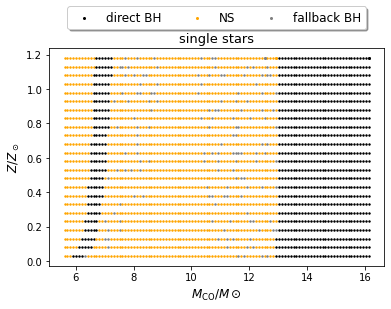

In [41]:
dz, dm = 0.05, 0.1 # sampling density in CO core mass and metallicity
z_vals = np.arange(0.03, 1.2, dz) # ZAMS metallicity range 
mco_vals = np.arange(mco_min, mco_max, dm) # CO core mass range

ff_plot(z_vals, mco_vals, 'None', 'Model A', ff_mco_z_fb, 'single stars')

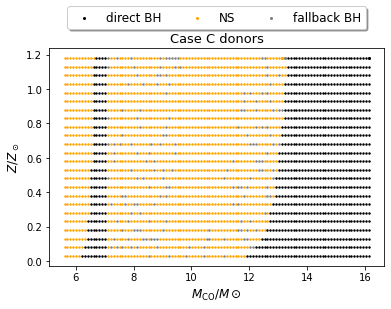

In [42]:
ff_plot(z_vals, mco_vals, 'C', 'Model A', ff_mco_z_fb, 'Case C donors')

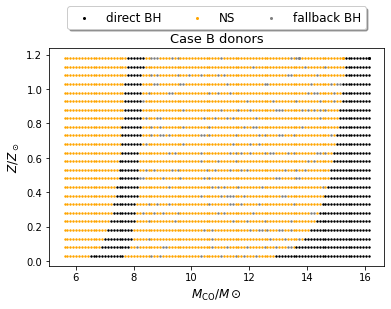

In [43]:
ff_plot(z_vals, mco_vals, 'B', 'Model A', ff_mco_z_fb, 'Case B donors')

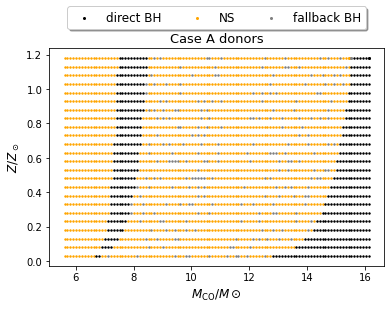

In [44]:
ff_plot(z_vals, mco_vals, 'A', 'Model A', ff_mco_z_fb, 'Case A donors')

## 4. How does the CCSN recipe work?

### threshold values in $M_\mathrm{CO}$ for BH formation by direct collapse
For $M_\mathrm{CO} < M_\mathrm{CO}^\mathrm{min}$, only NSs form, regardless of MT history and $Z$. 
<br>For $M_\mathrm{CO} > M_\mathrm{CO}^\mathrm{max}$, only direct collapse BHs form. 
<br>
<br> For $M_\mathrm{CO} \in (M_\mathrm{CO}^\mathrm{min}, M_\mathrm{CO}^\mathrm{max})$, final fates and remnant types co-exist and are assigned given the critical values $M_\mathrm{CO}$ that do depend on $Z$ and MT history class.

The tables *mco_explodz* and *mco_explodz10* contain the carbon-oxygen (CO) core masses $M_\mathrm{CO}^{(1)}$, $M_\mathrm{CO}^{(2)}$ and $M_\mathrm{CO}^{(3)}$ demarcating BH formation by direct collapse at two metallicities, $Z=Z_\odot$ and $Z = Z_\odot / 10$. These threshold masses differ among single stars, Case A, Case B or Case C binary-stripped stars. For a given $M_\mathrm{CO}$ of a star, these critical values are used as follows to look up the star's final fate and remnant type.

- $M_\mathrm{CO} < M_\mathrm{CO}^{(1)}$: successful supernova (SN) $\rightarrow$ NS formation,
- $M_\mathrm{CO}^{(1)} \leq M_\mathrm{CO} \leq M_\mathrm{CO}^{(2)}$: failed SN $\rightarrow$ direct BH formation,
- $M_\mathrm{CO}^{(2)} < M_\mathrm{CO} < M_\mathrm{CO}^{(3)}$: successful SN $\rightarrow$ NS or fallback BH formation,
- $M_\mathrm{CO} \geq M_\mathrm{CO}^{(3)}$: failed SN $\rightarrow$ direct BH formation.

For $M_\mathrm{CO} \geq M_\mathrm{CO}^{(3)}$, the plateau of direct BH formation outcomes is expected to extend up to the pair-instability mass gap.

### compact remnant left behind a successful SN:

In the case of a successful SN, we distinguish between two remnant types: a NS and a fallback BH. According to our recipe, BH formation by fallback may occur for $M_\mathrm{CO}^\mathrm{(2)} < M_\mathrm{CO}  < M_\mathrm{CO}^\mathrm{(3)}$, while for $M_\mathrm{CO} < M_\mathrm{CO}^{(1)}$ NS formation is guaranteed. We provide two different probabilistic fallback models (*Model A* and *Model B*), and suggest to use *Model A* as default. 

**Model A**: 
- if $M_\mathrm{CO}^\mathrm{(NS,1)} \leq M_\mathrm{CO} \leq M_\mathrm{CO}^\mathrm{(NS, 2)}$: guaranteed NS formation. 
- if $M_\mathrm{CO}^\mathrm{(2)} < M_\mathrm{CO}  < M_\mathrm{CO}^\mathrm{(3)}$ but $M_\mathrm{CO} \notin (M_\mathrm{CO}^\mathrm{(NS,1)}, M_\mathrm{CO}^\mathrm{(NS, 2)})$: fallback BH formation with probability $P = 0.15$, NS formation otherwise.

The tables *mco_nsz* and *mco_nsz10* contain pairs ($M_\mathrm{CO}^\mathrm{NS, 1}$ and $M_\mathrm{CO}^\mathrm{NS, 2}$) of CO core mass values (at two metallicities $Z=Z_\odot$ and $Z=Z_\odot/10$, respectively), over which fallback BH formation is excluded and NS formation expected.

**Model B**: 
<br> for $M_\mathrm{CO}^\mathrm{(2)} < M_\mathrm{CO}  < M_\mathrm{CO}^\mathrm{(3)}$: fallback BH formation occurs with a uniform probability of 10\%, regardless of MT history and $Z$.

### $Z$-dependence of BH formation boundaries in $M_\mathrm{CO}$

The threshold values $M_\mathrm{CO}^{(i)}$ (for i=1,2,3), demarcating the transition from successful to failed SNe and vice versa, are calculated as follows for arbitrary $Z$. We assume a linear $\log Z$ scaling of the boundaries $M_\mathrm{CO}^{(i)}$, 

- $M_\mathrm{CO}^\mathrm{(i)}(Z) = b + \log Z/Z_\odot \cdot m$

when moving from $M_\mathrm{CO}^{(i)}(Z_\odot / 10)$ to $M_\mathrm{CO}^{(i)}(Z_\odot)$ with increasing $Z$. We use the same approach to scale the guaranteed NS formation windows, predicted by fallback *Model A*, with $Z$.

The linear model $f(x) = b + m \cdot x$ has two free parameters $b$ and $m$, and we use the data points $\left( M_\mathrm{CO}^{(i)}\left(Z_\odot \right), Z_\odot \right)$ and $\left( M_\mathrm{CO}^{(i)}\left(Z_\odot \right), Z_\odot/10 \right)$ to determine these analytically. These are given by 
- $m = a_1 - a_2$, $b = a_1$
- where $(a_1, a_2) = (M_\mathrm{CO}^\mathrm{(i)}(Z_\odot), M_\mathrm{CO}^\mathrm{(i)}(Z_\odot/10))$ are the critical CO core mass values at $Z_\odot$ and at $Z_\odot/10$ that are given in the tables in solar mass units.

The method *ff_mco_z_fb()* reads in the CO core mass $M_\mathrm{CO}^\mathrm{in}$, ZAMS metallicity $Z^\mathrm{in}$ and MT history class of a test star. These are used to calculate the three fit parameter pairs $[(m_1, b_1), (m_2, b_2), (m_3, b_3)]$ of the $\log Z$ model for the scaling of the three direct BH formation boundaries $M_\mathrm{CO}^{(1)}, M_\mathrm{CO}^{(2)}, M_\mathrm{CO}^{(3)}$ with $Z$. A similar procedure is used to obtain the guarateed NS formation boundaries for fallback Model A. If $M_\mathrm{CO}^\mathrm{in}$ is in-between $M_\mathrm{CO}^\mathrm{(2)}(Z^\mathrm{in})$ and $M_\mathrm{CO}^\mathrm{(3)}(Z^\mathrm{in})$ but not contained within the guaranteed NS formation boundaries, a random number between 0 and 1 is drawn to assign the remnant type (NS or fallback BH) probabilistically. 

## 5. Practical remarks on application of the recipe

### MT history class assignment

**LBV**: 
<br> stars undergoing the luminous blue variable (LBV) phase of enhanced mass loss over a short (thermal or faster) timescale: we suggest to classify their explodability using the routines for Case B donors, rather than those for single stars.

**Accretor stars**
<br> Accretor stars that gain mass by stable mass transfer during the main sequence (MS) evolution: since they rejuvenate, their explodability can be approximated using the single star routines. This approximation breaks down for stars accreting mass during their post-MS evolution.

**Repeated MT**
<br> How about repeated MT episodes, such as Case AB, BC MT? Since the pre-SN properties of Case A and B progenitors are similar, whether MT class A or B is assigned to the star, does not substantially change the final CCSN outcome. The differences would be more apparent with Case BC MT. For such systems, we suggest to use the first MT episode for the classification, because Case C progenitors are closer to single stars, and the binary interaction effects are likely more adequately accounted for by the critical values we found for Case B donors. 

### Breakdown of the CCSN recipe

The usage of the CCSN recipe for $Z < Z_\odot/10$ and $Z > Z_\odot$ is extrapolation. Over these regimes, the recipe  has not been compared with outcomes of detailed stellar evolution models.  It is therefore not known at which metallicty regime the CCSN recipe breaks down. As a consequence of the imposed parametric $\log Z$ scaling law, the CCSN recipe not only predicts a smooth shift of the direct collapse windows in $M_\mathrm{CO}$ toward larger (lower) values as $Z$ increases (decreases), but also changes in its width. For Case A donors, this leads to the prediction that the direct collapse window vanishes altogether at $Z/Z_\odot$ close to 0.03, which is likely an artifact prediction. To cure this issue and remain more agnostic, a working assumption could be to use the recipe for extrapolation only down to $Z = Z_\odot/20$. For lower metallicities, we suggest to keep the critical CO core masses (of single, Case A, B, C donor stars) constant, with their values given by the cut-off  at $Z = Z_\odot/20$ (COMPAS assumptions).

### Compact remnant and SN properties
For the NS and BH masses, explosion energies, SN natal kick velocities, nucleosynthesis yields and other CCSN outcomes of interest, we suggest to use the default recipes that you currently have implemented or are implemented elsewhere. For example, to predict the **BH mass from direct collapse**, you could use Eq. (3) in [Mapelli et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...888...76M/abstract).

The **fallback BH remnant mass** determination is poorly constrained by 3D CCSN simulations and observations. In the context of rapid binary population synthesis with the COMPAS code, we assume that half of the mass outside the proto-NS falls back:
<br> *mass of fallback BH* = *estimated baryonic NS mass* + *half of the ejecta mass*.

In [1]:
## acknowledgement: Kiril Maltsev